In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


2025-12-12 18:42:44.585076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765564964.787616      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765564964.846784      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:

DATASET_PATH = "/kaggle/input/leapgestrecog/leapGestRecog"
IMG_SIZE = 64

class_names = [
    '01_palm', 
    '02_l',        
    '03_fist',      
    '04_fist_moved', 
    '05_thumb',     
    '06_index',      
    '07_ok',         
    '08_palm_moved', 
    '09_c',          
    '10_down'        
]

num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 10


## LOAD DATASET

In [3]:
def load_dataset(dataset_path, img_size=64):
    images = []
    labels = []
    
    subjects = sorted([d for d in os.listdir(dataset_path) 
                       if os.path.isdir(os.path.join(dataset_path, d))])
    
    print(f"Found {len(subjects)} subjects: {subjects}")
    
    for subject in tqdm(subjects, desc="Loading"):
        subject_path = os.path.join(dataset_path, subject)
        
        for gesture_folder in os.listdir(subject_path):
            gesture_path = os.path.join(subject_path, gesture_folder)
            
            if not os.path.isdir(gesture_path):
                continue
            
            if gesture_folder in class_names:
                class_idx = class_names.index(gesture_folder)
            else:
                continue
            
            for img_file in os.listdir(gesture_path):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(gesture_path, img_file)
                    
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize((img_size, img_size))
                        images.append(np.array(img))
                        labels.append(class_idx)
                    except Exception as e:
                        print(f"Error: {e}")
    
    return np.array(images), np.array(labels)

In [4]:
X, y = load_dataset(DATASET_PATH, IMG_SIZE)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {num_classes}")

Found 10 subjects: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


Loading: 100%|██████████| 10/10 [02:42<00:00, 16.28s/it]

X shape: (20000, 64, 64, 3)
y shape: (20000,)
Classes: 10


## SPLIT DATA

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain: {X_train.shape[0]} images")
print(f"Val:   {X_val.shape[0]} images")
print(f"Test:  {X_test.shape[0]} images")


Train: 14000 images
Val:   3000 images
Test:  3000 images


## Normalization

In [6]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# VGG-19 From Scratch 

In [7]:
vgg19_model = models.Sequential([
    layers.InputLayer(input_shape=(64, 64, 3)),
    
    # ============ block 1 (64 filters) ============
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
    
    # ============ block 2 (128 filters) ============
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),
    
    # ============ block 3 (256 filters) ============
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv3'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv4'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),
    
    # ============ block 4 (512 filters) ============
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv3'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv4'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'),
    
    # ============ block 5 (512 filters) ============
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv3'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv4'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'),
    
    # ============ Fully Connected Layers ============
    layers.Flatten(name='flatten'),
    
    layers.Dense(4096, kernel_initializer='he_normal', name='fc1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(4096, kernel_initializer='he_normal', name='fc2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    # output Layer
    layers.Dense(num_classes, activation='softmax', name='predictions')
])

vgg19_model.summary()
print(f"Total Parameters: {vgg19_model.count_params():,}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1765565146.913633      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765565146.914331      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,02

 Total params: 45,294,154 (172.78 MB)

 Trainable params: 45,266,762 (172.68 MB)

 Non-trainable params: 27,392 (107.00 KB)

Total Parameters: 45,294,154


In [8]:
vgg19_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
vgg19_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [10]:
BATCH_SIZE = 32
EPOCHS = 15

vgg19_history = vgg19_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=vgg19_callbacks,
    verbose=1
)

Epoch 1/15


I0000 00:00:1765565160.648579      65 service.cc:148] XLA service 0x7dab4c019220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765565160.649193      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765565160.649216      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765565162.192177      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/438 ━━━━━━━━━━━━━━━━━━━━ 2:44:06 23s/step - accuracy: 0.0000e+00 - loss: 3.4814

I0000 00:00:1765565172.724015      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - accuracy: 0.7578 - loss: 0.7705 - val_accuracy: 0.6047 - val_loss: 1.2218 - learning_rate: 1.0000e-04
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - accuracy: 0.9903 - loss: 0.0311 - val_accuracy: 0.9973 - val_loss: 0.0118 - learning_rate: 1.0000e-04
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.9954 - loss: 0.0166 - val_accuracy: 0.7453 - val_loss: 0.9809 - learning_rate: 1.0000e-04
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - accuracy: 0.9922 - loss: 0.0271 - val_accuracy: 0.9977 - val_loss: 0.0076 - learning_rate: 1.0000e-04
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - accuracy: 0.9960 - loss: 0.0131 - val_accuracy: 0.9230 - val_loss: 0.3568 - learning_rate: 1.0000e-04
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.6293 - val_loss: 1.7681 - learning_rate: 1.0000e-04
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - 

# EVALUATE MODEL

In [11]:
y_pred_proba = vgg19_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"VGG-19 RESULTS")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"{'='*50}")

class_labels = ['Palm', 'L', 'Fist', 'Fist_mov', 'Thumb', 
                'Index', 'OK', 'Palm_mov', 'C', 'Down']
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
VGG-19 RESULTS
Accuracy:  0.9997
Precision: 0.9997
Recall:    0.9997
F1-Score:  0.9997

Classification Report:
              precision    recall  f1-score   support

        Palm       1.00      1.00      1.00       300
           L       1.00      1.00      1.00       300
        Fist       1.00      1.00      1.00       300
    Fist_mov       1.00      1.00      1.00       300
       Thumb       1.00      1.00      1.00       300
       Index       1.00      1.00      1.00       300
          OK       1.00      1.00      1.00       300
    Palm_mov       1.00      1.00      1.00       300
           C       1.00      1.00      1.00       300
        Down       1.00      1.00      1.00       300

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



# VISUALIZATIONS

# Training History

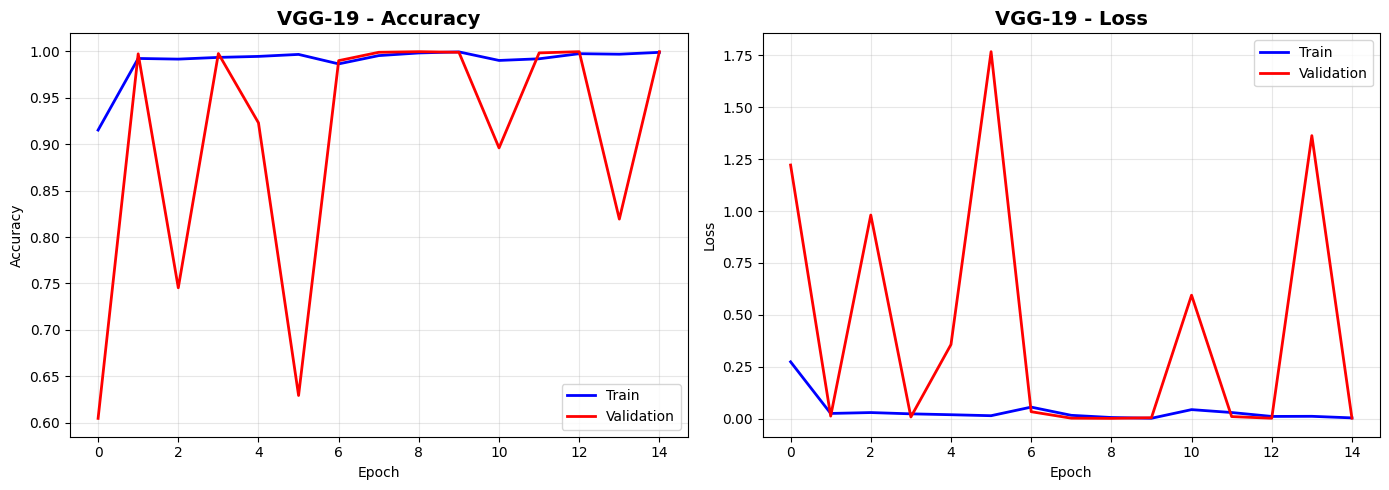

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# acc
axes[0].plot(vgg19_history.history['accuracy'], 'b-', linewidth=2, label='Train')
axes[0].plot(vgg19_history.history['val_accuracy'], 'r-', linewidth=2, label='Validation')
axes[0].set_title('VGG-19 - Accuracy', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# loss
axes[1].plot(vgg19_history.history['loss'], 'b-', linewidth=2, label='Train')
axes[1].plot(vgg19_history.history['val_loss'], 'r-', linewidth=2, label='Validation')
axes[1].set_title('VGG-19 - Loss', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vgg19_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## Confusion Matrix

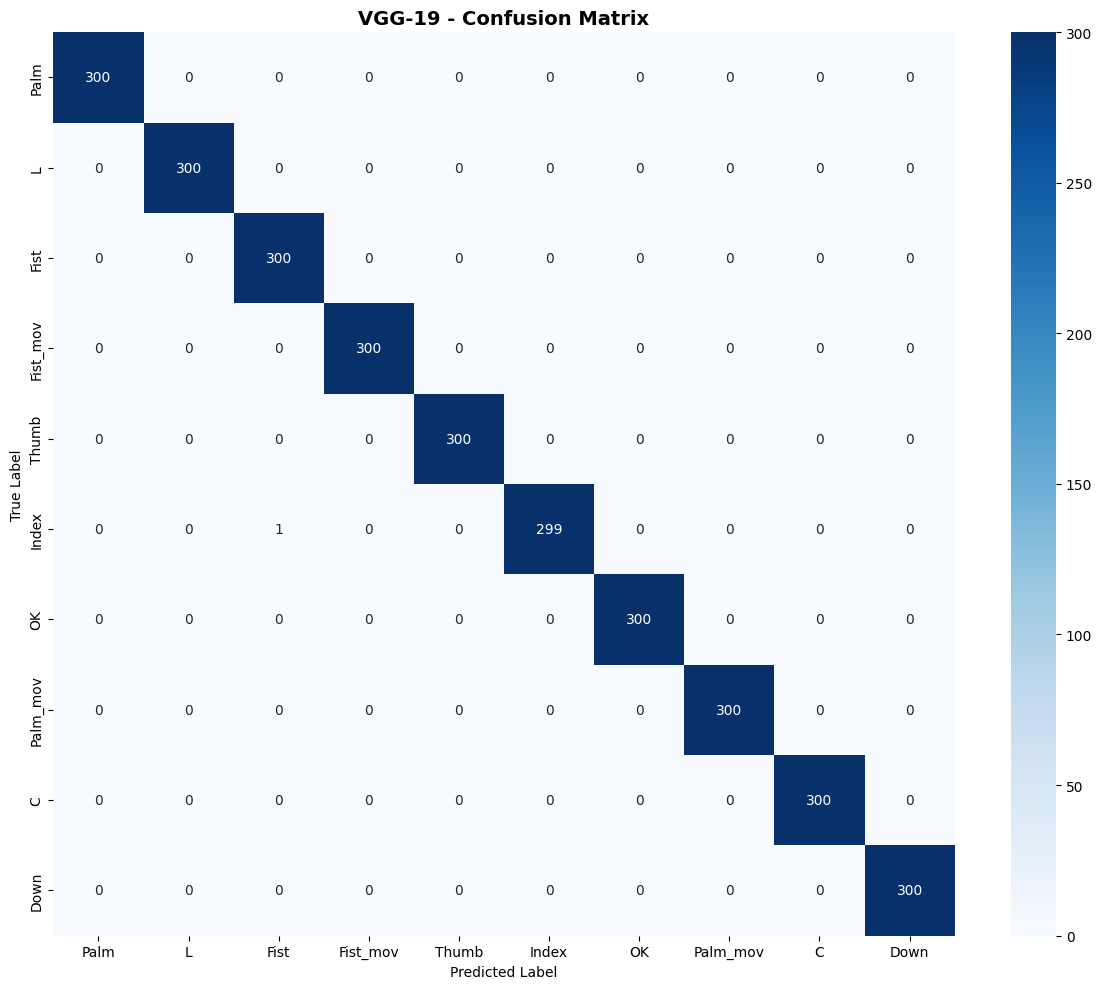

In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('VGG-19 - Confusion Matrix', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('vgg19_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


## ROC Curves

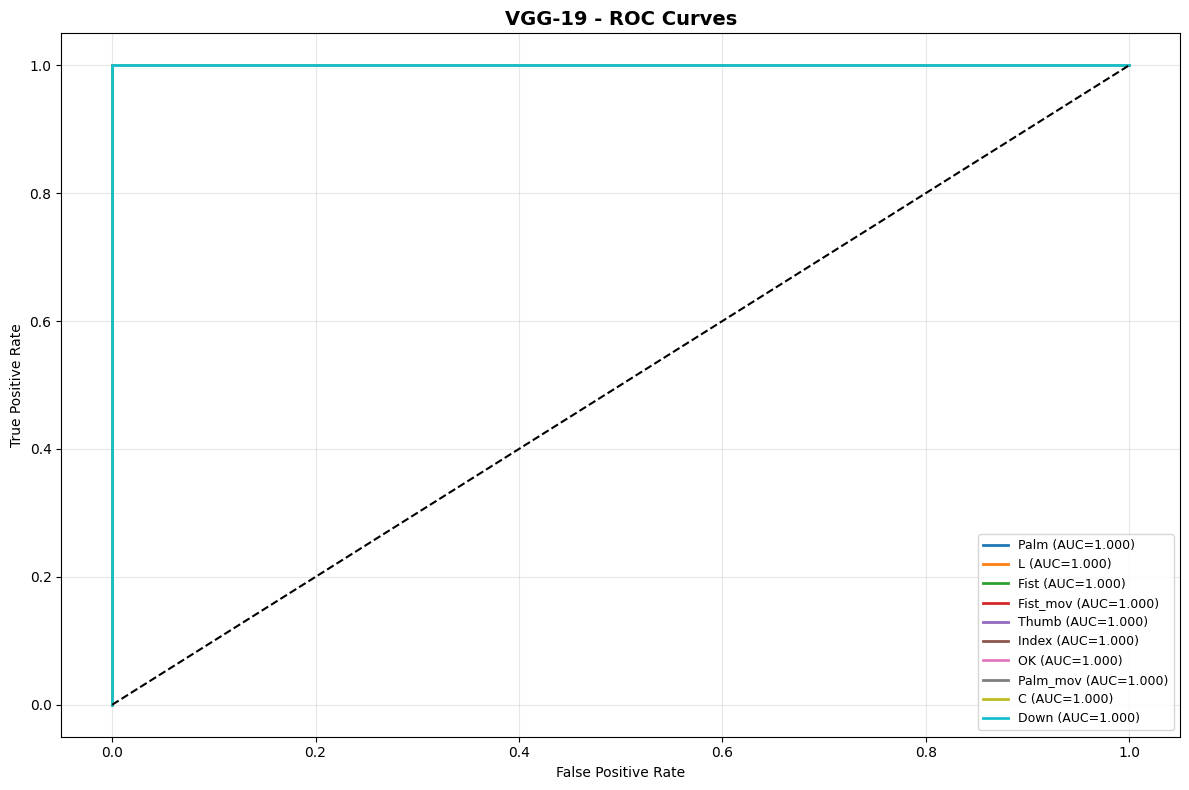


Mean AUC: 1.0000


In [14]:
y_test_bin = label_binarize(y_test, classes=range(num_classes))

plt.figure(figsize=(12, 8))

auc_scores = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, linewidth=2, label=f'{class_labels[i]} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.title('VGG-19 - ROC Curves', fontweight='bold', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('vgg19_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMean AUC: {np.mean(auc_scores):.4f}")

## STORE RESULTS

In [15]:
vgg19_results = {
    'model_name': 'VGG-19 (From Scratch)',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'auc_macro': np.mean(auc_scores),
    'y_pred': y_pred,
    'y_pred_proba': y_pred_proba,
    'history': vgg19_history.history
}

print("VGG-19 Results")
print(f"Model: {vgg19_results['model_name']}")
print(f"Accuracy: {vgg19_results['accuracy']:.4f}")
print(f"F1-Score: {vgg19_results['f1']:.4f}")
print(f"AUC: {vgg19_results['auc_macro']:.4f}")

VGG-19 Results
Model: VGG-19 (From Scratch)
Accuracy: 0.9997
F1-Score: 0.9997
AUC: 1.0000
